<a href="https://colab.research.google.com/github/tianyunh/BIOSTAT823-Project/blob/main/10_Code/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/tianyunh/BIOSTAT823-Project.git

In [93]:
import numpy as np
import pandas as pd
import cv2 # opencv
import matplotlib.pyplot as plt
# keras
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import seaborn as sns
import os
from sklearn.utils import shuffle
import glob
from warnings import filterwarnings
from sklearn.metrics import classification_report , confusion_matrix
from skimage import io
filterwarnings("ignore")

In [84]:
path  = "/content/BIOSTAT823-Project/00_Data/Face Mask Dataset/"

In [85]:
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [86]:
df = {"image_path":[],"category":[],"set":[]}
for folder in listdir_nohidden(path):
    for f2 in os.listdir(path+"/"+folder):
        for image in glob.glob(path+folder+"/"+f2+"/"+"*.png"):
            df["image_path"].append(image)
            df["category"].append(f2)
            df["set"].append(folder)
df = pd.DataFrame(df)
df

,image_path,category,set
0,/content/BIOSTAT823-Project/00_Data/Face Mask ...,WithoutMask,Train
1,/content/BIOSTAT823-Project/00_Data/Face Mask ...,WithoutMask,Train
2,/content/BIOSTAT823-Project/00_Data/Face Mask ...,WithoutMask,Train
3,/content/BIOSTAT823-Project/00_Data/Face Mask ...,WithoutMask,Train
4,/content/BIOSTAT823-Project/00_Data/Face Mask ...,WithoutMask,Train
...,...,...,...
11787,/content/BIOSTAT823-Project/00_Data/Face Mask ...,WithMask,Validation
11788,/content/BIOSTAT823-Project/00_Data/Face Mask ...,WithMask,Validation
11789,/content/BIOSTAT823-Project/00_Data/Face Mask ...,WithMask,Validation
11790,/content/BIOSTAT823-Project/00_Data/Face Mask ...,WithMask,Validation


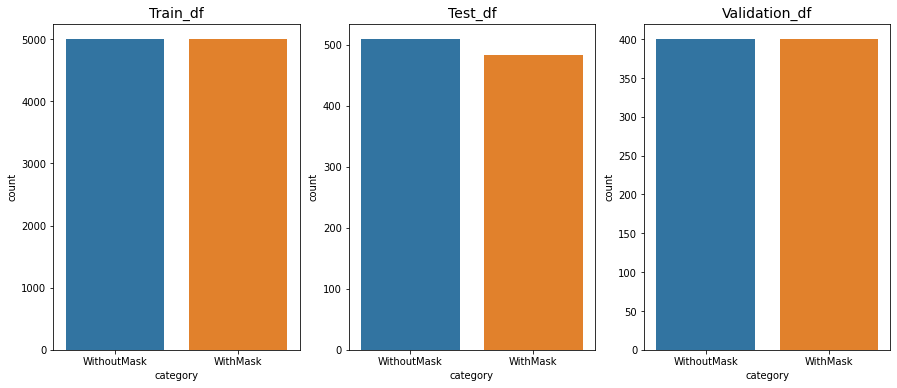

In [90]:
train_df = df[df["set"] == "Train"]
test_df = df[df["set"] == "Test"]
valid_df = df[df["set"] == "Validation"]

plt.figure(figsize = (15,6))
plt.subplot(1,3,1)
sns.countplot(train_df["category"])
plt.title("Train_df", size = 14)


plt.subplot(1,3,2)
sns.countplot(test_df["category"])
plt.title("Test_df", size = 14)


plt.subplot(1,3,3)
sns.countplot(valid_df["category"])
plt.title("Validation_df", size = 14)

plt.show()

In [6]:
# Load data
train_dir = '/content/BIOSTAT823-Project/00_Data/Face Mask Dataset/Train'
test_dir = '/content/BIOSTAT823-Project/00_Data/Face Mask Dataset/Test'
val_dir = '/content/BIOSTAT823-Project/00_Data/Face Mask Dataset/Validation'

Found 10000 files belonging to 2 classes.


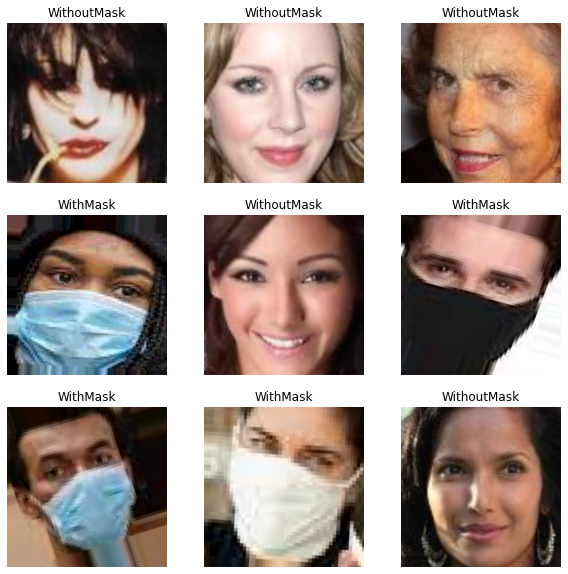

In [91]:
train = keras.utils.image_dataset_from_directory(train_dir,
                                                 batch_size=32,
                                                 shuffle=True)
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train.class_names[labels[i]])
    plt.axis("off")

In [32]:
train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32,seed=42,shuffle = False)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32,seed=42,shuffle = False)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(directory=test_dir,target_size=(128,128),class_mode='categorical',batch_size=32,seed=42,shuffle = False)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [33]:
# customize CNN
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same',input_shape=(128,128,3)),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 128)     

In [34]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

cnn_history = model.fit(train_generator,batch_size=32,epochs=30,
        validation_data=val_generator)

Epoch 1/30
313/313 [==============================] - 50s 155ms/step - loss: 0.7254 - accuracy: 0.7884 - val_loss: 0.1751 - val_accuracy: 0.9250
Epoch 2/30
313/313 [==============================] - 49s 157ms/step - loss: 0.1503 - accuracy: 0.9441 - val_loss: 0.0813 - val_accuracy: 0.9737
Epoch 3/30
313/313 [==============================] - 48s 152ms/step - loss: 0.0741 - accuracy: 0.9721 - val_loss: 0.0220 - val_accuracy: 0.9900
Epoch 4/30
313/313 [==============================] - 48s 152ms/step - loss: 0.0466 - accuracy: 0.9842 - val_loss: 0.0226 - val_accuracy: 0.9900
Epoch 5/30
313/313 [==============================] - 48s 154ms/step - loss: 0.0504 - accuracy: 0.9824 - val_loss: 0.1262 - val_accuracy: 0.9500
Epoch 6/30
313/313 [==============================] - 48s 153ms/step - loss: 0.0569 - accuracy: 0.9812 - val_loss: 0.0199 - val_accuracy: 0.9925
Epoch 7/30
313/313 [==============================] - 48s 153ms/step - loss: 0.0448 - accuracy: 0.9839 - val_loss: 0.0260 - val_ac

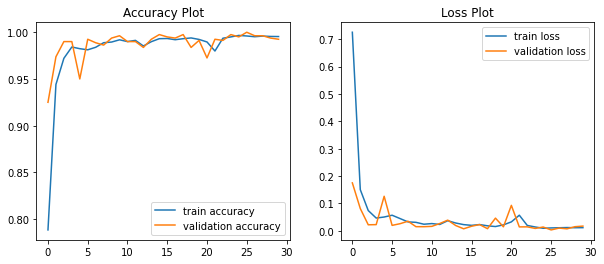

In [54]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(cnn_history.history["accuracy"], label = "train accuracy")
plt.plot(cnn_history.history["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.title('Accuracy Plot')

plt.subplot(1,2,2)
plt.plot(cnn_history.history["loss"], label = "train loss")
plt.plot(cnn_history.history["val_loss"], label = "validation loss")
plt.title('Loss Plot')
plt.legend()
plt.show()

In [36]:
# vgg19

vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_5 (Dense)             (None, 2)                 16386     
                                                                 
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [37]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

vgg19_history = model.fit(train_generator,batch_size=32,epochs=30,
        validation_data=val_generator)

Epoch 1/30
313/313 [==============================] - 52s 163ms/step - loss: 0.1565 - accuracy: 0.9388 - val_loss: 0.0375 - val_accuracy: 0.9900
Epoch 2/30
313/313 [==============================] - 51s 163ms/step - loss: 0.0541 - accuracy: 0.9808 - val_loss: 0.0202 - val_accuracy: 0.9975
Epoch 3/30
313/313 [==============================] - 51s 162ms/step - loss: 0.0419 - accuracy: 0.9854 - val_loss: 0.0223 - val_accuracy: 0.9925
Epoch 4/30
313/313 [==============================] - 51s 162ms/step - loss: 0.0327 - accuracy: 0.9907 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 5/30
313/313 [==============================] - 50s 160ms/step - loss: 0.0297 - accuracy: 0.9884 - val_loss: 0.0296 - val_accuracy: 0.9862
Epoch 6/30
313/313 [==============================] - 50s 161ms/step - loss: 0.0318 - accuracy: 0.9889 - val_loss: 0.0148 - val_accuracy: 0.9925
Epoch 7/30
313/313 [==============================] - 51s 161ms/step - loss: 0.0242 - accuracy: 0.9925 - val_loss: 0.0093 - val_ac

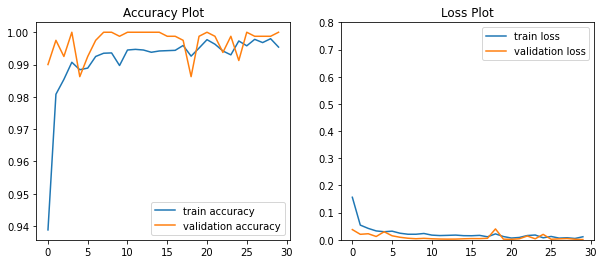

In [55]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(vgg19_history.history["accuracy"], label = "train accuracy")
plt.plot(vgg19_history.history["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.title('Accuracy Plot')

plt.subplot(1,2,2)
plt.plot(vgg19_history.history["loss"], label = "train loss")
plt.plot(vgg19_history.history["val_loss"], label = "validation loss")
plt.ylim([0, 0.8])
plt.title('Loss Plot')
plt.legend()
plt.show()

In [43]:
# resnet
resnet101v2 = ResNet101V2(weights='imagenet',include_top=False,input_shape=(128,128,3))
# make pre trained model into non trainable bcoz its takes much time
for layer in resnet101v2.layers:
    layer.trainable = False

model = Sequential()
# add resnet101v2 model into our sequence model
model.add(resnet101v2)
# flatten the model
model.add(Flatten())
# Adding output layer
model.add(Dense(2,activation='sigmoid')) #two classes
model.summary()

171317808/171317808 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 4, 4, 2048)        42626560  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 2)                 65538     
                                                                 
Total params: 42,692,098
Trainable params: 65,538
Non-trainable params: 42,626,560
_________________________________________________________________


In [44]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

resnet_history = model.fit(train_generator,batch_size=32,epochs=30,
        validation_data=val_generator)

Epoch 1/30
313/313 [==============================] - 62s 178ms/step - loss: 0.2029 - accuracy: 0.9840 - val_loss: 0.0018 - val_accuracy: 0.9987
Epoch 2/30
313/313 [==============================] - 52s 167ms/step - loss: 0.0467 - accuracy: 0.9968 - val_loss: 0.0463 - val_accuracy: 0.9962
Epoch 3/30
313/313 [==============================] - 52s 165ms/step - loss: 0.0421 - accuracy: 0.9959 - val_loss: 0.0206 - val_accuracy: 0.9975
Epoch 4/30
313/313 [==============================] - 52s 166ms/step - loss: 0.0595 - accuracy: 0.9971 - val_loss: 0.0230 - val_accuracy: 0.9975
Epoch 5/30
313/313 [==============================] - 52s 166ms/step - loss: 0.0366 - accuracy: 0.9981 - val_loss: 0.0291 - val_accuracy: 0.9975
Epoch 6/30
313/313 [==============================] - 51s 164ms/step - loss: 0.0145 - accuracy: 0.9988 - val_loss: 0.0298 - val_accuracy: 0.9987
Epoch 7/30
313/313 [==============================] - 52s 165ms/step - loss: 0.0280 - accuracy: 0.9980 - val_loss: 0.0103 - val_ac

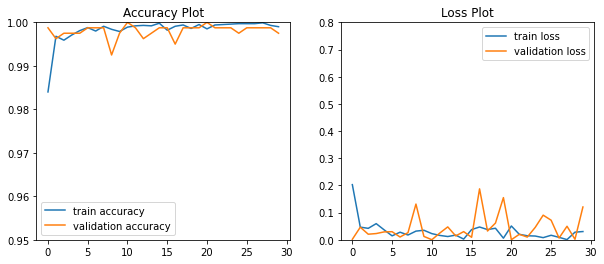

In [56]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(resnet_history.history["accuracy"], label = "train accuracy")
plt.plot(resnet_history.history["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.title('Accuracy Plot')
plt.ylim([0.95, 1])

plt.subplot(1,2,2)
plt.plot(resnet_history.history["loss"], label = "train loss")
plt.plot(resnet_history.history["val_loss"], label = "validation loss")
plt.ylim([0, 0.8])
plt.title('Loss Plot')
plt.legend()
plt.show()

# validation loss osiliate > overfitting

In [62]:
# resnet
resnet101v2 = ResNet101V2(weights='imagenet',include_top=False,input_shape=(128,128,3))
# make pre trained model into non trainable bcoz its takes much time
for layer in resnet101v2.layers:
    layer.trainable = False

model = Sequential()
# add resnet101v2 model into our sequence model
model.add(resnet101v2)
# flatten the model
model.add(Flatten())
# Adding output layer
model.add(Dense(2,activation='sigmoid')) #two classes
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 4, 4, 2048)        42626560  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 2)                 65538     
                                                                 
Total params: 42,692,098
Trainable params: 65,538
Non-trainable params: 42,626,560
_________________________________________________________________


In [63]:
model.compile(optimizer=Adam(0.0005),loss="categorical_crossentropy",metrics ="accuracy")

resnet_history2 = model.fit(train_generator,batch_size=32,epochs=30,
        validation_data=val_generator)

Epoch 1/30
313/313 [==============================] - 60s 174ms/step - loss: 0.1051 - accuracy: 0.9857 - val_loss: 0.0456 - val_accuracy: 0.9937
Epoch 2/30
313/313 [==============================] - 53s 169ms/step - loss: 0.0275 - accuracy: 0.9965 - val_loss: 0.0294 - val_accuracy: 0.9962
Epoch 3/30
313/313 [==============================] - 54s 172ms/step - loss: 0.0134 - accuracy: 0.9980 - val_loss: 0.0282 - val_accuracy: 0.9975
Epoch 4/30
313/313 [==============================] - 53s 170ms/step - loss: 0.0187 - accuracy: 0.9980 - val_loss: 0.0177 - val_accuracy: 0.9987
Epoch 5/30
313/313 [==============================] - 54s 172ms/step - loss: 0.0272 - accuracy: 0.9970 - val_loss: 0.0231 - val_accuracy: 0.9962
Epoch 6/30
313/313 [==============================] - 53s 170ms/step - loss: 0.0101 - accuracy: 0.9986 - val_loss: 0.0040 - val_accuracy: 0.9975
Epoch 7/30
313/313 [==============================] - 54s 172ms/step - loss: 0.0213 - accuracy: 0.9984 - val_loss: 0.0142 - val_ac

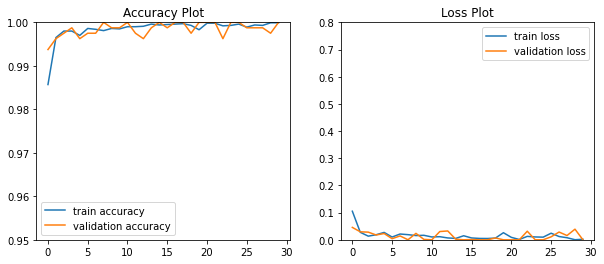

In [64]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(resnet_history2.history["accuracy"], label = "train accuracy")
plt.plot(resnet_history2.history["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.title('Accuracy Plot')
plt.ylim([0.95, 1])

plt.subplot(1,2,2)
plt.plot(resnet_history2.history["loss"], label = "train loss")
plt.plot(resnet_history2.history["val_loss"], label = "validation loss")
plt.ylim([0, 0.8])
plt.title('Loss Plot')
plt.legend()
plt.show()

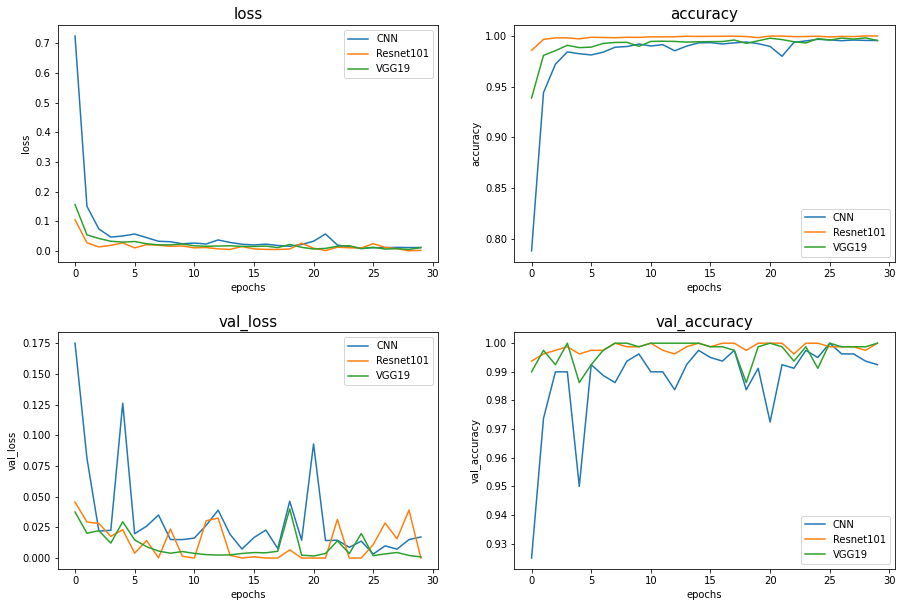

In [65]:
model_hist = [cnn_history,resnet_history2,vgg19_history]
names = ['CNN','Resnet101','VGG19']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)
for metric in model_hist[0].history:
    index = list(model_hist[0].history).index(metric)
    ax = axes.flatten()[index]
    name_index = 0
    for history in model_hist:
        ax.plot(history.history[metric], label=names[name_index])
        name_index += 1
    ax.set_title(metric, size=15)
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.legend()
plt.show()



In [67]:
# retrain

# resnet
resnet101v2 = ResNet101V2(weights='imagenet',include_top=False,input_shape=(128,128,3))
# make pre trained model into non trainable bcoz its takes much time
for layer in resnet101v2.layers:
    layer.trainable = False

model = Sequential()
# add resnet101v2 model into our sequence model
model.add(resnet101v2)
# flatten the model
model.add(Flatten())
# Adding output layer
model.add(Dense(2,activation='sigmoid')) #two classes

model.compile(optimizer=Adam(0.0005),loss="categorical_crossentropy",metrics ="accuracy")

# Using EarlyStopping, end training when val_accuracy is not improved for 4 consecutive times
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',
                                patience=5,restore_best_weights=True)
# training
history = model.fit(train_generator,batch_size=32,epochs=30,
        validation_data=val_generator,callbacks=[early_stopping])

Epoch 1/30
313/313 [==============================] - 61s 177ms/step - loss: 0.1689 - accuracy: 0.9794 - val_loss: 0.0045 - val_accuracy: 0.9987
Epoch 2/30
313/313 [==============================] - 55s 175ms/step - loss: 0.0240 - accuracy: 0.9964 - val_loss: 0.0051 - val_accuracy: 0.9975
Epoch 3/30
313/313 [==============================] - 54s 172ms/step - loss: 0.0092 - accuracy: 0.9977 - val_loss: 0.0057 - val_accuracy: 0.9975
Epoch 4/30
313/313 [==============================] - 53s 170ms/step - loss: 0.0099 - accuracy: 0.9981 - val_loss: 0.0115 - val_accuracy: 0.9975
Epoch 5/30
313/313 [==============================] - 53s 168ms/step - loss: 0.0128 - accuracy: 0.9977 - val_loss: 0.0037 - val_accuracy: 0.9975
Epoch 6/30
313/313 [==============================] - 53s 171ms/step - loss: 0.0099 - accuracy: 0.9988 - val_loss: 0.0191 - val_accuracy: 0.9975


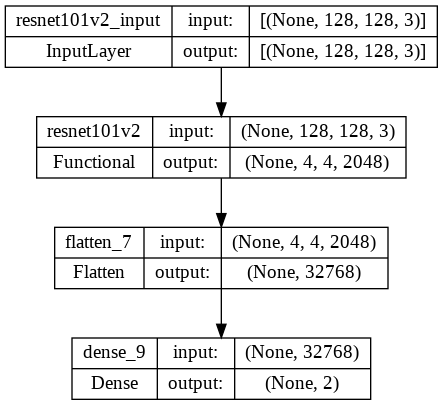

In [94]:
keras.utils.plot_model(model, show_shapes=True)

In [68]:
model.evaluate(test_generator)

31/31 [==============================] - 3s 84ms/step - loss: 0.0136 - accuracy: 0.9970


[0.013582893647253513, 0.9969757795333862]

31/31 [==============================] - 2s 76ms/step


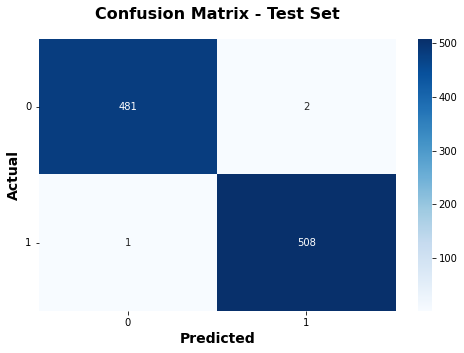

In [82]:
prediction = model.predict(test_generator)
pred_prob = []
for p in prediction:
  pred_prob.append(p[1])

test_pred = np.argmax(prediction,axis = 1)

plt.figure(figsize = (8,5))
ax = sns.heatmap(confusion_matrix(test_generator.labels, test_pred), annot = True,fmt="d",cmap = "Blues")

ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20)
plt.show()

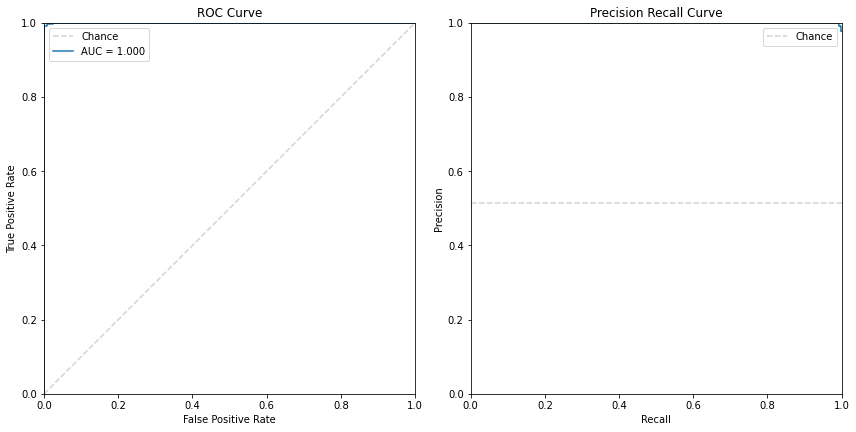

In [83]:
# calculate fraction of positive examples for future plots
test_label = test_generator.labels
fraction_positive_examples = np.count_nonzero(test_label == 1)/len(test_label)
fraction_positive_examples

from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score

# plot ROC curve and precision-recall curve
# initialize each plot
fig, axs = plt.subplots(1,2,figsize=(12,6))

# plot the chance diagonal and PR random chance lines
axs[0].plot((0,1),(0,1),color='lightgrey',linestyle='--', label='Chance')
axs[1].plot((0,1),(fraction_positive_examples, fraction_positive_examples),color='lightgrey',linestyle='--', label='Chance')

# get fpr, tpr, precision, recall, auc for plots
fpr, tpr, _ = roc_curve(test_label, pred_prob)
precision, recall, _ = precision_recall_curve(test_label, pred_prob)
roc_auc = auc(fpr,tpr)

# plot ROC curve
axs[0].plot(fpr, tpr, label='AUC = {:.3f}'.format(roc_auc))
    
# plot the PR curve
axs[1].plot(recall, precision)

for ax in axs:
    ax.axis('square')
    ax.set(xlim=(0,1), ylim=(0,1))
    ax.legend()
axs[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve')
axs[1].set(xlabel='Recall', ylabel='Precision', title='Precision Recall Curve')
plt.tight_layout()
plt.show()



In [73]:
face_model = cv2.CascadeClassifier('/content/BIOSTAT823-Project/00_Data/haarcascade/haarcascade_frontalface_default.xml')

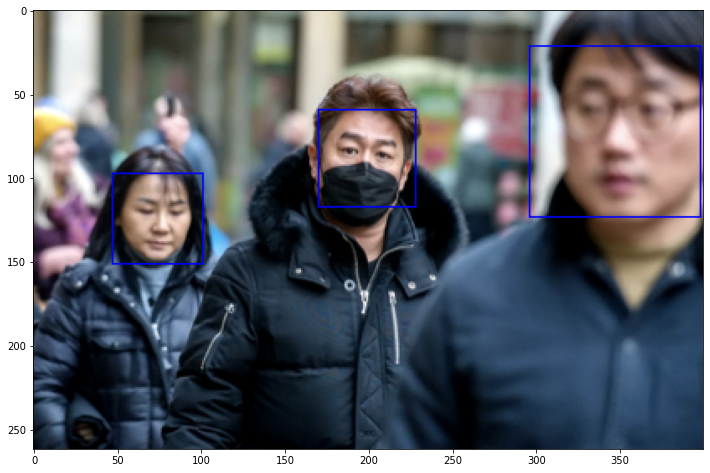

In [74]:
import matplotlib.pyplot as plt
#trying it out on a sample image
img = cv2.imread('/content/BIOSTAT823-Project/00_Data/Predict Sample/maksssksksss244.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

In [75]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)} # rectangle color

def plot_image(image,subplot):
    plt.subplot(*subplot)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show

def predict_image(image_dir):
    img = cv2.imread(image_dir)
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    
    #returns a list of (x,y,w,h) tuples
    faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)
    
    out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    plt.figure(figsize=(20,20))
    plot_image(out_img,(1,2,1))

    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = out_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop).argmax()
        cv2.rectangle(out_img,(x,y),(x+w,y+h),dist_label[mask_result],1)
    
    plot_image(out_img,(1,2,2))

1/1 [==============================] - 0s 24ms/step


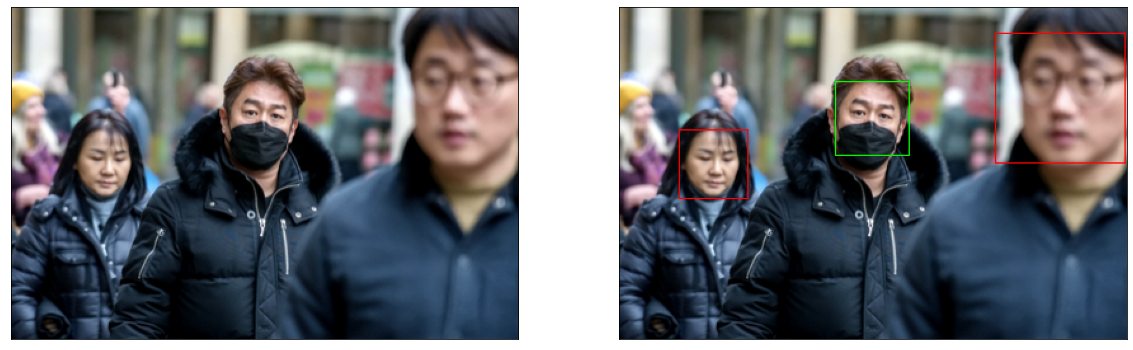

In [76]:
predict_image("/content/maksssksksss244.png")